In [1]:
# Import needed libraries 

import pandas as pd 
import os
import datetime
from datetime import timedelta
import numpy as np 
from scipy.signal import argrelextrema
import alpaca_trade_api as tradeapi 
import matplotlib.pyplot as plt 
import matplotlib.dates as mpdates
from mplfinance.original_flavor import candlestick_ohlc
from dotenv import load_dotenv
from itertools import islice
from pandas .tseries.offsets import DateOffset

In [2]:
# Load .env file

load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")


# Create the Alpaca API object
api = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    api_version="v2",
    base_url= ALPACA_ENDPOINT_KEY
)

In [4]:
# Parameters for Stock Data from Alpacas
# Establish time frame (5 minute)

time_frame = "5min"

# Identify what stock symbol is trading

stock_symbol = "QQQ"

# Identify what start date to begin data analysis

start_date = pd.Timestamp("2021-01-01", tz="America/New_York").isoformat()

# Identify what end date to finalize data analysis

end_date = pd.Timestamp("2022-06-30", tz="America/New_York").isoformat()

In [5]:
print(start_date)
print(end_date)

2021-01-01T00:00:00-05:00
2022-06-30T00:00:00-04:00


In [6]:
# Function to call daily stock data

def get_stock_data(api, stock_symbol, time_frame, start_date, end_date):
    
    # Assuming api.get_bars returns a DataFrame with a 'df' attribute
    
    stock_data = api.get_bars(
        stock_symbol, 
        time_frame, 
        start=start_date, 
        end=end_date
        ).df
    return stock_data

stock_data = get_stock_data(api, stock_symbol, time_frame, start_date, end_date)

# Displays the information pulled for working through code

stock_data.info()
display(stock_data.head())
display(stock_data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69596 entries, 2021-01-04 09:00:00+00:00 to 2022-06-29 23:55:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        69596 non-null  float64
 1   high         69596 non-null  float64
 2   low          69596 non-null  float64
 3   trade_count  69596 non-null  int64  
 4   open         69596 non-null  float64
 5   volume       69596 non-null  int64  
 6   vwap         69596 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 4.2 MB


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-04 09:00:00+00:00,315.40,315.40,315.06,31,315.06,10945,315.330200
2021-01-04 09:05:00+00:00,315.38,315.38,315.30,22,315.32,4117,315.319021
2021-01-04 09:10:00+00:00,315.39,315.44,315.38,26,315.38,5591,315.400816
2021-01-04 09:15:00+00:00,315.54,315.62,315.46,31,315.46,4803,315.552297
2021-01-04 09:20:00+00:00,315.62,315.66,315.54,33,315.54,5013,315.601365


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2022-06-29 23:35:00+00:00,283.5600,283.6300,283.50,20,283.50,2563,283.561908
2022-06-29 23:40:00+00:00,283.6599,283.6599,283.59,15,283.59,1013,283.608717
2022-06-29 23:45:00+00:00,283.6200,283.7400,283.62,33,283.66,2474,283.671896
2022-06-29 23:50:00+00:00,283.6300,283.6300,283.60,12,283.60,783,283.606053
2022-06-29 23:55:00+00:00,283.6300,283.6500,283.58,32,283.58,4308,283.599156


In [9]:
# Function to prepare daily stock data to identify double top/bottom patterns and prepare for targets
# Includes establishing a polynomial fit and assigning new columns for localized min/max

# Polynomial Degree

polynomial_degree = 50

def polynomial_min_max_fit(stock_data, polynomial_degree):
    
    min_length = len(stock_data.index)
    x_data = np.arange(min_length)

    # Polynomial fitting
    polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
    polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
    polynomial_coefficients_low = np.polyfit(x_data, stock_data['low'][:min_length], polynomial_degree)
    polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)

    # Evaluate the polynomial fit for plotting
    y_polynomial_open = np.polyval(polynomial_coefficients_open, x_data)
    y_polynomial_high = np.polyval(polynomial_coefficients_high, x_data)
    y_polynomial_low = np.polyval(polynomial_coefficients_low, x_data)
    y_polynomial_close = np.polyval(polynomial_coefficients_close, x_data)

    # Identify local extrema for polynomial fit data (minima and maxima)
    local_poly_minima = argrelextrema(y_polynomial_close, np.less, order=5)[0]
    local_poly_maxima = argrelextrema(y_polynomial_close, np.greater, order=5)[0]

    # Convert the close price polynomial fit data into a dataframe
    # This is done for OHLC poly fit data

    poly_df = pd.DataFrame(y_polynomial_open)
    columns = ['poly_fit_open']
    poly_df.columns = columns
    poly_df = poly_df.assign(poly_fit_high = y_polynomial_high)
    poly_df = poly_df.assign(poly_fit_low = y_polynomial_low)
    poly_df = poly_df.assign(poly_fit_close = y_polynomial_close)

    # Reset the index of the original updated ticker dataframe to concat with the polynomial dataframe that does not include a timeseries
    # This will ensure that the indexed intergers of the ploynomial fit align with the time each data point corresponds to

    updated_stock_data = stock_data.reset_index()
    updated_stock_data = pd.concat([updated_stock_data, poly_df], axis='columns', join='inner')
    updated_stock_data.head()

    # Add minima and maxima column to the DataFrame

    updated_stock_data["minima"] = 0
    updated_stock_data["maxima"] = 0
    updated_stock_data.head()

    # Mark rows with local minima as 1 in the 'minima' column

    for index in local_poly_minima:
        updated_stock_data.at[index, 'minima'] = -1

    for index in local_poly_maxima:
        updated_stock_data.at[index, "maxima"] = 1

    # Create Target Columns - Double Top Target & Double Bottom Target
        
    updated_stock_data["dbl_top_target"] = 0
    updated_stock_data["dbl_bot_target"] = 0

    # # Plot data: COMMENTED OUT TO NOT REPEAT PLOTS AT END OF PROGRAM
    # # Plot the stock data and identified minima

    # plt.figure(figsize=(15, 5))
    # plt.plot(stock_data.index, stock_data["close"], label='Close Prices', alpha=0.7)

    # # Plot polynomial fit

    # plt.plot(stock_data.index[:min_length], y_polynomial_close, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

    # # Plot red dots at local minima and blue dots at local maxima

    # plt.scatter(stock_data.index[local_poly_minima], y_polynomial_close[local_poly_minima], color='red', label='Local Minima')
    # plt.scatter(stock_data.index[local_poly_maxima],y_polynomial_close[local_poly_maxima], color="blue", label = "Local Maxima")
    
    return updated_stock_data


# For data checking/confirmation
updated_stock_data = polynomial_min_max_fit(stock_data,polynomial_degree)
updated_stock_data.head()

c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\numpy\lib\polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_34304\3282563817.py:14: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_34304\3282563817.py:15: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_34304\3282563817.py:16: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_low = np.polyfit

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,2021-01-04 09:00:00+00:00,315.40,315.40,315.06,31,315.06,10945,315.330200,321.595224,321.704088,321.441134,321.586768,0,0,0,0
1,2021-01-04 09:05:00+00:00,315.38,315.38,315.30,22,315.32,4117,315.319021,321.554901,321.663973,321.400707,321.546471,0,0,0,0
2,2021-01-04 09:10:00+00:00,315.39,315.44,315.38,26,315.38,5591,315.400816,321.514657,321.623936,321.360358,321.506252,0,0,0,0
3,2021-01-04 09:15:00+00:00,315.54,315.62,315.46,31,315.46,4803,315.552297,321.474491,321.583977,321.320089,321.466112,0,0,0,0
4,2021-01-04 09:20:00+00:00,315.62,315.66,315.54,33,315.54,5013,315.601365,321.434404,321.544096,321.279898,321.426051,0,0,0,0


C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_34304\2995550416.py:11: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)


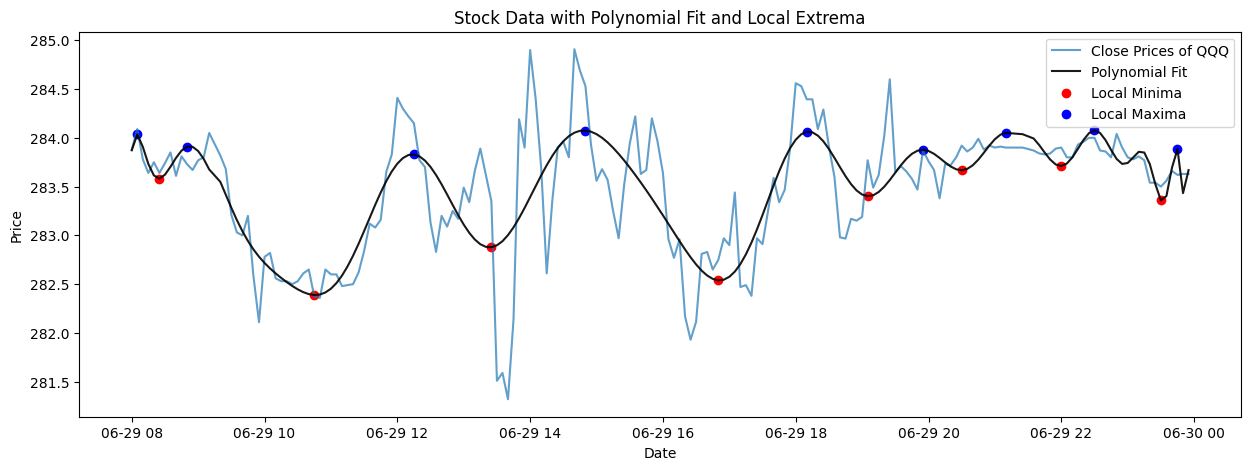

In [19]:
# Plot data
# Plot the stock data and identified minima

plt.figure(figsize=(15, 5))
plt.plot(stock_data.index, stock_data["close"], label='Close Prices of QQQ', alpha=0.7)

# # Plot polynomial fit

min_length = len(stock_data.index)
x_data = np.arange(min_length)
polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)
y_polynomial_close = np.polyval(polynomial_coefficients_close, x_data)
local_poly_minima = argrelextrema(y_polynomial_close, np.less, order=5)[0]
local_poly_maxima = argrelextrema(y_polynomial_close, np.greater, order=5)[0]


plt.plot(stock_data.index[:min_length], y_polynomial_close, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# # Plot red dots at local minima and blue dots at local maxima

plt.scatter(stock_data.index[local_poly_minima], y_polynomial_close[local_poly_minima], color='red', label='Local Minima')
plt.scatter(stock_data.index[local_poly_maxima],y_polynomial_close[local_poly_maxima], color="blue", label = "Local Maxima")

# Add titles and labels
plt.title('Stock Data with Polynomial Fit and Local Extrema')
plt.xlabel('Date')
plt.ylabel('Price')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [11]:
# Define the time independent DF for double top/bottom identification
# Timestamp remains a column, but can identify pattern from peak to peak immediately

def time_independent_data(updated_stock_data):

    # Define and establish time independent DF

    time_independent_df = []
    time_independent_df = pd.DataFrame(time_independent_df, columns = ["timestamp","close","high","low","trade_count","open","volume","vwap","poly_fit_open","poly_fit_high","poly_fit_low","poly_fit_close","minima","maxima", "dbl_top_target","dbl_bot_target"])

    # Loop to iterate through all rows of stock data and write min/max to new DF

    for index, row in islice(updated_stock_data.iterrows(), 0, None):

        # Assign to rows only those that contain local min or max

        if (updated_stock_data.at[index,"minima"] == -1):
            time_independent_df.loc[index] = row
            a = updated_stock_data.iloc[index]["poly_fit_close"]
        elif (updated_stock_data.at[index,"maxima"] == 1):
            time_independent_df.loc[index] = row
            a = updated_stock_data.iloc[index]["poly_fit_close"]

    # Reset time dependent index
    # Set new time independent index

    time_independent_df.reset_index(inplace = True)
    time_independent_df.rename(columns={"index":"time_dependent_index"}, inplace = True)

    return time_independent_df

# Data confirmation/check

time_independent_df = time_independent_data(updated_stock_data)
time_independent_df.head(10)

,time_dependent_index,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,782,2021-01-08 10:35:00+00:00,316.37,316.37,316.32,10,316.32,2938,316.339564,308.300059,308.481144,308.120682,308.30498,-1,0,0,0
1,3799,2021-02-02 15:15:00+00:00,327.44,327.48,326.3008,4887,326.43,629217,326.84075,331.722348,331.874006,331.558976,331.719528,0,1,0,0
2,8167,2021-03-08 23:15:00+00:00,301.85,301.85,301.4,166,301.4,23348,301.672962,315.369702,315.614868,315.116468,315.365367,-1,0,0,0
3,15177,2021-04-30 13:35:00+00:00,338.49,338.7,337.85,7602,338.0,848534,338.218782,333.655118,333.792473,333.515737,333.656581,0,1,0,0
4,17658,2021-05-19 19:40:00+00:00,321.115,321.53,321.02,4869,321.5,625485,321.310444,332.842963,332.98704,332.6984,332.84367,-1,0,0,0
5,28963,2021-08-17 12:40:00+00:00,366.94,367.07,366.89,188,366.95,55926,366.98617,373.476206,373.593874,373.355579,373.473366,0,1,0,0
6,34069,2021-09-27 11:55:00+00:00,371.34,371.46,371.23,104,371.29,18920,371.325228,366.889781,367.0337,366.743865,366.888775,-1,0,0,0
7,43157,2021-12-06 12:20:00+00:00,381.49,381.49,381.25,324,381.31,24478,381.387912,398.508156,398.698089,398.312203,398.504108,0,1,0,0
8,54351,2022-03-03 15:25:00+00:00,345.0,345.28,344.53,8446,344.9,866552,345.003488,338.124164,338.459831,337.784127,338.127976,-1,0,0,0
9,58689,2022-04-05 18:50:00+00:00,362.665,362.96,362.54,3840,362.74,443180,362.748159,356.103007,356.315586,355.882709,356.098782,0,1,0,0


In [12]:
# Function to identify daily double top/bottom patterns
# Inherently there should only be 1 identification of the pattern as it is considered a trend reversal pattern
# The loop will break once the pattern is identified

def identify_double_patterns(time_independent_df, updated_stock_data):

    # Initialize variables to identify double top/bottom patterns
    # Time dependent variable x_0 will always begin at a local min/max which also coincides
    # With the start of a trend into a potential double top/bottom
    
    x_0 = 0

    # Initiation of double top/bottom variable
    
    a = 0

    # First peak/valley of double top/bottom pattern
    
    b = 0

    # Trough/peak of double top/bottom pattern

    c = 0

    # Second peak/vallye of double top/bottom pattern
    
    d = 0

    # Trigger of double top/bottom pattern
    
    e = 0

    # Final time increment to finalize and trigger double top signal
    
    x_f = 0

    # Read through code to identify double top/bottom and assign to target columns.

    for index, row in islice(time_independent_df.iterrows(), 0, len(time_independent_df) - 4):

        # Check for double top
        # If found then assigns x_f final time for writing to targets in time dependent dataframe

        if (time_independent_df.at[index,"minima"] == -1):
            a = time_independent_df.iloc[index]["poly_fit_close"]
            b = time_independent_df.iloc[index + 1]["poly_fit_close"]
            c = time_independent_df.iloc[index + 2]["poly_fit_close"]
            d = time_independent_df.iloc[index + 3]["poly_fit_close"]
            e = time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0 = time_independent_df.iloc[index]["time_dependent_index"]

            if (time_independent_df.iloc[index + 1]["poly_fit_low"])*.95 < d < (time_independent_df.iloc[index + 1]["poly_fit_high"])*1.05 and (e <= c):
                x_f = time_independent_df.iloc[index + 4]["time_dependent_index"]
                updated_stock_data.at[x_f, "long_short_target"] = -1
                while (x_0 < x_f + 1):
                    updated_stock_data.at[x_0, "dbl_top_target"] = 1
                    x_0 = x_0 + 1
                break
            
            

        # Check for double bottom
        # If found then assigns x_f final time for writing to targets in time dependent dataframe
            
        elif (time_independent_df.at[index,"maxima"] == 1):
            a = time_independent_df.iloc[index]["poly_fit_close"]
            b = time_independent_df.iloc[index + 1]["poly_fit_close"]
            c = time_independent_df.iloc[index + 2]["poly_fit_close"]
            d = time_independent_df.iloc[index + 3]["poly_fit_close"]
            e = time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0 = time_independent_df.iloc[index]["time_dependent_index"] 

            if (time_independent_df.iloc[index+1]["poly_fit_low"])*.95 < d < (time_independent_df.iloc[index+1]["poly_fit_high"])*1.05 and (e >= c):
                x_f_min = time_independent_df.iloc[index + 4]["time_dependent_index"]
                updated_stock_data.at[x_f, "long_short_target"] = 1
                while (x_0 < x_f + 1):
                    updated_stock_data.at[x_0, "dbl_bot_target"] = 1
                    x_0 = x_0 + 1
                break
            
    return updated_stock_data, x_f

updated_stock_data, x_f = identify_double_patterns(time_independent_df,updated_stock_data)

#print(x_f)

0


In [13]:
# Loop to collect and assess daily data one day at a time

master_df = {
    'timestamp': [],  # List of timestamps
    'close': [],      # List of close prices
    'high': [],       # List of high prices
    'low': [],        # List of low prices
    'trade_count': [], # List of trade counts
    'open': [],       # List of open prices
    'volume': [],     # List of volumes
    'vwap': [],       # List of volume-weighted average prices
    'poly_fit_open': [],    # List of polynomial fit open prices
    'poly_fit_high': [],    # List of polynomial fit high prices
    'poly_fit_low': [],     # List of polynomial fit low prices
    'poly_fit_close': [],   # List of polynomial fit close prices
    'minima': [],           # List of minima
    'maxima': [],           # List of maxima
    'dbl_top_target': [],   # List of double top targets
    'dbl_bot_target': [],    # List of double bottom targets
    'long_short_target': []       # List of ML Model target
}

daily_dataframes = []

master_df = pd.DataFrame(master_df)

current_date = pd.to_datetime(start_date)
next_day_date = current_date + pd.offsets.BDay(1)

print(current_date)
print(next_day_date)

while current_date <= (pd.to_datetime(end_date)):

    # next_day_date = next_day_date + pd.offsets.BDay(1)
    # current_date = current_date + pd.offsets.BDay(1)
    # Convert current_date and next_day_date to ISO format for API call

    current_date_iso = current_date.isoformat()
    # next_day_date = current_date + pd.offsets.BDay(1)
    next_day_date_iso = next_day_date.isoformat()

    #current_date = datetime.datetime.fromisoformat(current_date_iso) + pd.offsets.BDay(1)
    
    # Fetch stock data for the current day

    stock_data = get_stock_data(api, stock_symbol, time_frame, current_date_iso, next_day_date_iso)

    if len(stock_data.index) == 0:
        next_day_date = next_day_date + pd.offsets.BDay(1)
        current_date = current_date + pd.offsets.BDay(1)
        continue
    
    # Run polynomial fit function for updated stock data

    updated_stock_data = polynomial_min_max_fit(stock_data, polynomial_degree)
    
    # Isolate Mins/maxes

    time_independent_df = time_independent_data(updated_stock_data)

    # Updated stock data with double tops/bots identified by function
    # x_f is the double top/bot trigger row(index) for current day's double top/bot

    updated_stock_data, x_f = identify_double_patterns(time_independent_df, updated_stock_data)
    
    # Perform your analysis or call your functions here
    # e.g., identify_double_patterns(time_independent_df, updated_stock_data)

    daily_dataframes.append(updated_stock_data)

    master_df = pd.concat(daily_dataframes, ignore_index=True)
    # display(master_df.tail())
    # Increment to the next day

    next_day_date = next_day_date + pd.offsets.BDay(1)
    current_date = current_date + pd.offsets.BDay(1)
    # next_day_date = pd.Timestamp(next_day_date_iso) + pd.offsets.BDay(1)
    
    # print(current_date)
    # print(next_day_date)
    

2021-01-01 00:00:00-05:00
2021-01-04 00:00:00-05:00


C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_34304\3282563817.py:14: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_34304\3282563817.py:15: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_34304\3282563817.py:16: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_low = np.polyfit(x_data, stock_data['low'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_34304\3282563817.py:17: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_34304\3282563817.py:14: RankWarning: Pol

In [14]:
# Shift master dataframe by one datapoint to set target columns to train  ML model 

master_df['close_lagged'] = master_df['close'].shift(1)
master_df['high_lagged'] = master_df['high'].shift(1)
master_df['low_lagged'] = master_df['low'].shift(1)
master_df['open_lagged'] = master_df['open'].shift(1)
master_df['trade_count_lagged'] = master_df['trade_count'].shift(1)
master_df['volume_lagged'] = master_df['volume'].shift(1)
master_df['vwap_lagged'] = master_df['vwap'].shift(1)
master_df['poly_open_lagged'] = master_df['poly_fit_open'].shift(1)
master_df['poly_high_lagged'] = master_df['poly_fit_high'].shift(1)
master_df['poly_low_lagged'] = master_df['poly_fit_low'].shift(1)
master_df['poly_close_lagged'] = master_df['poly_fit_close'].shift(1)
master_df['minima_lagged'] = master_df['minima'].shift(1)
master_df['maxima_lagged'] = master_df['maxima'].shift(1)
master_df['dbl_top_target_lagged'] = master_df['dbl_top_target'].shift(1)
master_df['dbl_bot_target_lagged'] = master_df['dbl_bot_target'].shift(1)
master_df['long_short_target_lagged'] = master_df['long_short_target'].shift(1)

In [16]:
# Convert the NaN values within both tagret columns into 0's to feed into ML Models
master_df['long_short_target'] = master_df['long_short_target'].fillna(0)
master_df['long_short_target_lagged'] = master_df['long_short_target_lagged'].fillna(0)
master_df = master_df.drop(0)

master_df.info()
print(len(master_df))
print(type(master_df))
print(sum(master_df["dbl_top_target"]))
print(sum(master_df["dbl_bot_target"]))
print(sum(master_df["long_short_target"]))
display(master_df.head())
display(master_df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69595 entries, 1 to 69595
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   timestamp                 69595 non-null  datetime64[ns, UTC]
 1   close                     69595 non-null  float64            
 2   high                      69595 non-null  float64            
 3   low                       69595 non-null  float64            
 4   trade_count               69595 non-null  int64              
 5   open                      69595 non-null  float64            
 6   volume                    69595 non-null  int64              
 7   vwap                      69595 non-null  float64            
 8   poly_fit_open             69595 non-null  float64            
 9   poly_fit_high             69595 non-null  float64            
 10  poly_fit_low              69595 non-null  float64            
 11  poly_fit_close 

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
1,2021-01-04 09:05:00+00:00,315.38,315.38,315.30,22,315.32,4117,315.319021,315.259976,315.391157,...,315.330200,315.091775,315.405712,315.069538,315.407602,0.0,0.0,0.0,0.0,0.0
2,2021-01-04 09:10:00+00:00,315.39,315.44,315.38,26,315.38,5591,315.400816,315.382134,315.450973,...,315.319021,315.259976,315.391157,315.273449,315.370677,-1.0,0.0,1.0,0.0,0.0
3,2021-01-04 09:15:00+00:00,315.54,315.62,315.46,31,315.46,4803,315.552297,315.476666,315.537450,...,315.400816,315.382134,315.450973,315.394824,315.415392,0.0,0.0,1.0,0.0,0.0
4,2021-01-04 09:20:00+00:00,315.62,315.66,315.54,33,315.54,5013,315.601365,315.550746,315.620746,...,315.552297,315.476666,315.537450,315.472915,315.492492,0.0,0.0,1.0,0.0,0.0
5,2021-01-04 09:25:00+00:00,315.54,315.60,315.54,19,315.60,4166,315.564304,315.606088,315.684357,...,315.601365,315.550746,315.620746,315.527345,315.570806,0.0,0.0,1.0,0.0,0.0


,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
69591,2022-06-29 23:35:00+00:00,283.5600,283.6300,283.50,20,283.50,2563,283.561908,283.410173,283.452828,...,283.496317,283.433786,283.427984,283.354605,283.358529,-1.0,0.0,0.0,0.0,0.0
69592,2022-06-29 23:40:00+00:00,283.6599,283.6599,283.59,15,283.59,1013,283.608717,283.622692,283.747616,...,283.561908,283.410173,283.452828,283.371452,283.403420,0.0,0.0,0.0,0.0,0.0
69593,2022-06-29 23:45:00+00:00,283.6200,283.7400,283.62,33,283.66,2474,283.671896,283.811776,283.948900,...,283.608717,283.622692,283.747616,283.616566,283.693287,0.0,0.0,0.0,0.0,0.0
69594,2022-06-29 23:50:00+00:00,283.6300,283.6300,283.60,12,283.60,783,283.606053,283.480809,283.454959,...,283.671896,283.811776,283.948900,283.809256,283.884156,0.0,1.0,0.0,0.0,0.0
69595,2022-06-29 23:55:00+00:00,283.6300,283.6500,283.58,32,283.58,4308,283.599156,283.601743,283.684602,...,283.606053,283.480809,283.454959,283.463319,283.432996,0.0,0.0,0.0,0.0,0.0
